In [1]:
# Las Librerías utilizadas en el proyecto TFM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score


In [2]:
# Pruebas visualización inline Jupyter
%matplotlib inline

In [2]:
# En esta parte pillo de mi ruta el csv, cambiar la ruta dónde tengáis el csv chicos y lo de abajo son pruebas que para ver que se lea bien
df = pd.read_csv('C:/Users/Adelardo/Downloads/loan.csv', nrows=100000) 

print("Primeras 5 filas del dataset:")
print(df.head())
print("\nInformación del dataset (tipos de datos y nulos):")
print(df.info())

C:\Users\Adelardo\AppData\Local\Temp\ipykernel_15260\3964864968.py:2: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/Adelardo/Downloads/loan.csv', nrows=100000)


Primeras 5 filas del dataset:
   id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN       2500         2500             2500   36 months   
1 NaN        NaN      30000        30000            30000   60 months   
2 NaN        NaN       5000         5000             5000   36 months   
3 NaN        NaN       4000         4000             4000   36 months   
4 NaN        NaN      30000        30000            30000   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.56        84.92     C        C1  ...                            NaN   
1     18.94       777.23     D        D2  ...                            NaN   
2     17.97       180.69     D        D1  ...                            NaN   
3     18.94       146.51     D        D2  ...                            NaN   
4     16.14       731.78     C        C4  ...                            NaN   

  hardship_last_payment_amount disbursement_method

In [3]:
# Pocesamiento de los datos

# Lo comentado transformamos 'loan_status' a binaria, siendo 1 malo y 0 que va bien el cliente 

impago_estados = ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)']
df['target'] = df['loan_status'].apply(lambda x: 1 if x in impago_estados else 0)
print(f"\nDistribución de la variable objetivo 'target':\n{df['target'].value_counts()}")
print(f"Porcentaje de impago: {df['target'].mean() * 100:.2f}%")

# Las nuevas variables que interpreto poco importantes, es decor, ID, descripciones, o del estilo, lo elimino por irrevelevanica, y loan_estatus se elimina ya que tenemos target
columnas_a_eliminar = [
    'id', 'member_id', 'url', 'desc', 'emp_title', 'title', 'zip_code', 'review_status_d',
    'accept_d', 'credit_pull_d', 'list_d', 'exp_d', 'ils_exp_d', 'loan_status',
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
    'last_credit_pull_d', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
    'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status',
    'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
    'grade', 'sub_grade', 
    'policy_code', 
    'mthsSinceLastDelinq', 'mthsSinceLastRecord', 'mthsSinceMostRecentInq', 
    'annual_inc_joint', 'dti_joint', 'revol_bal_joint', 'verification_status_joint', 
    'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
    'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 
    'msa', 
]

# Comprobaciones y filtramos solo las columnas que realmente existen en el DataFrame para no liar
df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns], inplace=True)
print(f"\nColumnas eliminadas: {[col for col in columnas_a_eliminar if col in df.columns]}")
print(f"Dimensiones del DataFrame después de eliminar columnas: {df.shape}")

# Manejo de los valores, que queremos ahora, convertir a string para consistencia antes de imputar categóricas)
for col in df.select_dtypes(include=['object']).columns:
    if len(df[col].unique()) > 200: 
        print(f"Considera eliminar o tratar '{col}' de otra manera (muchas categorías únicas: {len(df[col].unique())})")
    df[col] = df[col].astype(str) # Asegura que todas las 'object' sean strings


# Convertir los valores a meses pero con control de errores 
if 'earliest_cr_line' in df.columns:
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
    most_recent_date = df['earliest_cr_line'].max() 
    df['cr_line_age_months'] = ((most_recent_date - df['earliest_cr_line']).dt.days / 30).astype(int)
    # Eliminar la columna original si ya se ha transformado
    df.drop('earliest_cr_line', axis=1, inplace=True)
    print("\n'earliest_cr_line' transformada a 'cr_line_age_months'.")
else:
    print("\n'earliest_cr_line' no encontrada para Feature Engineering.")


# Aquí ya chicos empezamos a dividir entre features (X) y variable objetivo (y)
X = df.drop('target', axis=1)
y = df['target']

# Identificar columnas numéricas y categóricas para el ColumnTransformer
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nCaracterísticas Numéricas: {numeric_features}")
print(f"Características Categóricas: {categorical_features}")

# Definir transformadores para el preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Rellena nulos con la mediana como comentamos con Antonio
    ('scaler', StandardScaler()) 
])

# Para categóricas: OneHotEncoder. handle_unknown='ignore' previene errores si una nueva categoría aparece en el futuro.SimpleImputer con 'missing' para nulos en categóricas antes de OneHotEncoder.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Rellena nulos con una cadena 'missing' de nuevo 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # esto es un porsiacaso
)


Distribución de la variable objetivo 'target':
target
0    99540
1      460
Name: count, dtype: int64
Porcentaje de impago: 0.46%

Columnas eliminadas: []
Dimensiones del DataFrame después de eliminar columnas: (100000, 98)
Considera eliminar o tratar 'earliest_cr_line' de otra manera (muchas categorías únicas: 638)

'earliest_cr_line' transformada a 'cr_line_age_months'.

Características Numéricas: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'i

In [4]:
#  División en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nDimensiones de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}, y_test: {y_test.shape}")


Dimensiones de X_train: (70000, 97), y_train: (70000,)
Dimensiones de X_test: (30000, 97), y_test: (30000,)


In [5]:
#  Entrenamiento del modelo Random Forest con el Pipeline (esta mejora chicos del pipeline es por lo visto en las últimas clases)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)) # n_jobs=-1 para usar todos los cores
                               ])

print("\nEntrenando el modelo...")
model_pipeline.fit(X_train, y_train)
print("✅ Modelo Random Forest entrenado exitosamente con Pipeline de preprocesamiento.")


Entrenando el modelo...
✅ Modelo Random Forest entrenado exitosamente con Pipeline de preprocesamiento.



Realizando predicciones y evaluando el modelo en el conjunto de test...

📋 Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29862
           1       0.00      0.00      0.00       138

    accuracy                           1.00     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.99      1.00      0.99     30000



C:\Users\Adelardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adelardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adelardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_cla

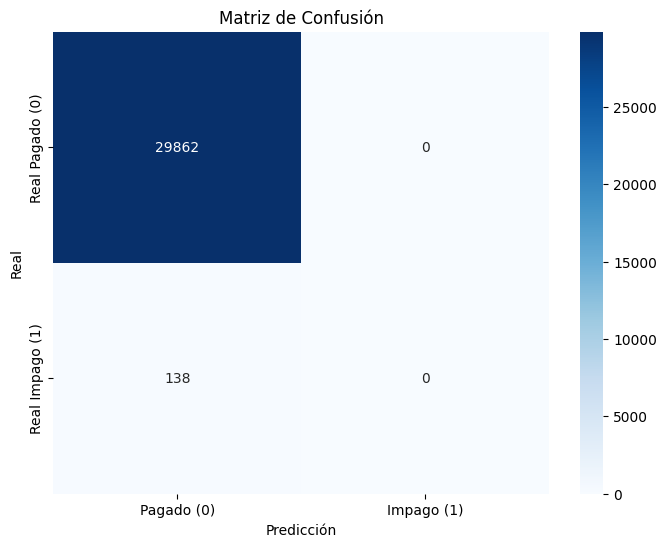

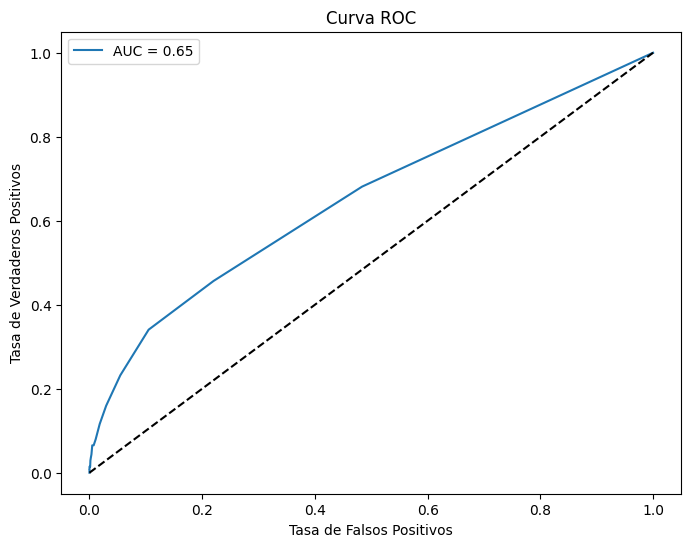


Área bajo la curva ROC (AUC): 0.6520
Precisión General (Accuracy): 0.9954


In [6]:
#  Evaluación del modelo

print("\nRealizando predicciones y evaluando el modelo en el conjunto de test...")
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1] 

print("\n📋 Informe de clasificación:")
print(classification_report(y_test, y_pred))

#Nueva Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pagado (0)', 'Impago (1)'], yticklabels=['Real Pagado (0)', 'Real Impago (1)'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#Nueva Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--') # Línea de base aleatoria
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"\nÁrea bajo la curva ROC (AUC): {auc_score:.4f}")
print(f"Precisión General (Accuracy): {accuracy_score(y_test, y_pred):.4f}")


Umbrales de probabilidad para los deciles: [0.0, 0.005, 0.01, 0.015, 0.175]

📊 Análisis de Deciles del Modelo (0 = menor riesgo, 9 = mayor riesgo):
   decil      N  Positivos  Negativos  Tasa_Default Riesgo_Desc
0      3   1665         32       1633      1.921922     Decil 6
1      2   1517         15       1502      0.988794     Decil 7
2      1   3454         16       3438      0.463231     Decil 8
3      0  23364         75      23289      0.321007     Decil 9


C:\Users\Adelardo\AppData\Local\Temp\ipykernel_15260\285150666.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Riesgo_Desc', y='Tasa_Default', data=analisis_deciles, palette='viridis')


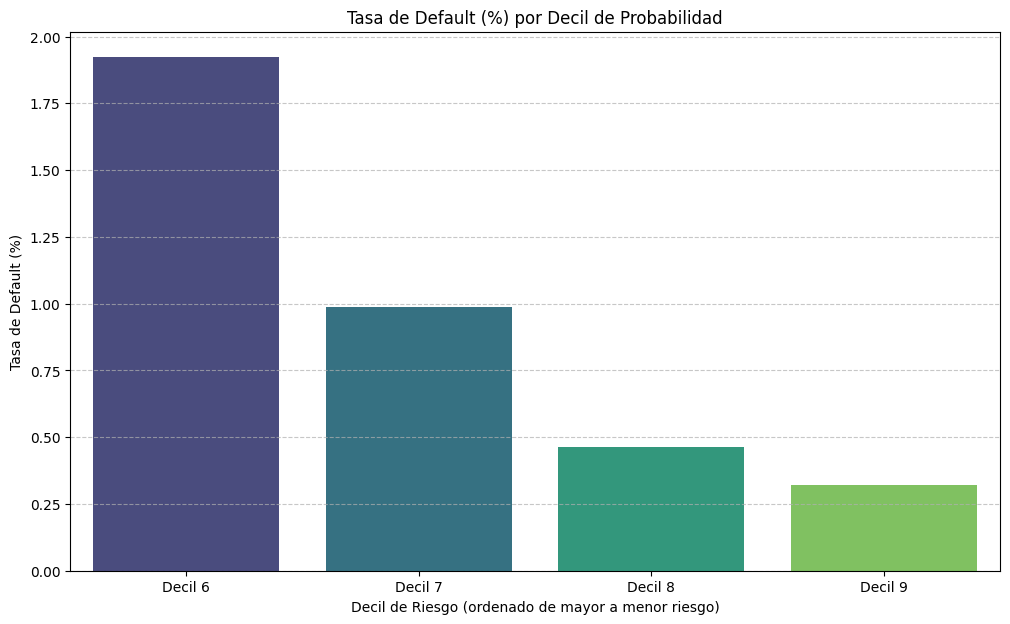

In [8]:
# Para visualizar la nueva mejora de separar en deciles 

resultados_test = pd.DataFrame({'probabilidad': y_proba, 'target': y_test})
resultados_test = resultados_test.sort_values(by='probabilidad', ascending=False).reset_index(drop=True)

# Crear 10 deciles por lo comentado de Antonio de subir a más deciles 
num_deciles = 10
resultados_test['decil'] = pd.qcut(resultados_test['probabilidad'], num_deciles, labels=False, duplicates='drop')
probabilidad_min_por_decil = resultados_test.groupby('decil')['probabilidad'].min().sort_index(ascending=False)
decil_thresholds = resultados_test.groupby('decil')['probabilidad'].max().sort_index(ascending=True).tolist()
decil_mapping = {}
for i in range(num_deciles):
    #  es un for básico para el umbral para el decil i es la probabilidad máxima de ese decil.Queremos que decil 0 sea el de menor riesgo y decil 9 el de mayor
    if i == 0:
        lower_bound = 0
    else:
        lower_bound = resultados_test[resultados_test['decil'] == i-1]['probabilidad'].max()

    upper_bound = resultados_test[resultados_test['decil'] == i]['probabilidad'].max()
    decil_mapping[f"Decil {i}"] = (lower_bound, upper_bound) 

# Para usarlo en la interfaz, necesitamos los puntos de corte, ordenados.
prob_thresholds = [0] + resultados_test['probabilidad'].quantile(np.arange(1, num_deciles) / num_deciles).tolist() + [1]
# Ajustamos para tener 10 umbrales que dividan 10 deciles
decile_cutoffs = np.unique(pd.qcut(y_proba, 10, retbins=True, labels=False, duplicates='drop')[1]).tolist()
print(f"\nUmbrales de probabilidad para los deciles: {decile_cutoffs}")

# Calcular métricas por decil
analisis_deciles = resultados_test.groupby('decil').agg(
    N=('target', 'count'),
    Positivos=('target', lambda x: (x == 1).sum()),
    Negativos=('target', lambda x: (x == 0).sum()),
    Tasa_Default=('target', lambda x: (x == 1).mean() * 100) # En porcentaje
).reset_index()

# Para visualizarlo en manera descendente lo hacemos así 
analisis_deciles['Riesgo_Desc'] = analisis_deciles['decil'].apply(lambda x: f"Decil {9-x}")
analisis_deciles = analisis_deciles.sort_values(by='decil', ascending=False).reset_index(drop=True)


print("\n📊 Análisis de Deciles del Modelo (0 = menor riesgo, 9 = mayor riesgo):")
print(analisis_deciles)

# Visualización del análisis de deciles
plt.figure(figsize=(12, 7))
sns.barplot(x='Riesgo_Desc', y='Tasa_Default', data=analisis_deciles, palette='viridis')
plt.title('Tasa de Default (%) por Decil de Probabilidad')
plt.xlabel('Decil de Riesgo (ordenado de mayor a menor riesgo)')
plt.ylabel('Tasa de Default (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [9]:
#  Guardar Modelo y Artefactos de Preprocesamiento, si no entendeís el nombre, este bloque de código sirve más que nada para guardar todos los elementos importantes del modelo ya entrenado para que luego puedan usarse en la interfaz de Gradio, sin necesidad de reentrenar nada

import os

print(f"\nGuardando artefactos en el directorio: {os.getcwd()}")

# Guarda el pipeline completo
joblib.dump(model_pipeline, 'modelo_riesgo_crediticio_pipeline.pkl')
print("✅ Pipeline del modelo guardado como 'modelo_riesgo_crediticio_pipeline.pkl'")

# Guarda la lista de nombres de columnas que el pipeline espera.
columnas_originales_entrenamiento = X.columns.tolist()
with open('columnas_originales_entrenamiento.json', 'w') as f:
    json.dump(columnas_originales_entrenamiento, f)
print("Nombres de columnas originales de entrenamiento guardados como 'columnas_originales_entrenamiento.json'")

# Guarda las categorías únicas de las variables categóricas usadas para OneHotEncoder
categorical_encoder = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_categories = categorical_encoder.categories_
# Crear un diccionario mapeando el nombre original de la columna a sus categorías
categorical_features_with_categories = {
    col: list(ohe_categories[i])
    for i, col in enumerate(categorical_features)
}
with open('categorical_features_with_categories.json', 'w') as f:
    json.dump(categorical_features_with_categories, f)
print("Categorías de variables categóricas guardadas como 'categorical_features_with_categories.json'")

# Guardar los umbrales de probabilidad para los deciles
with open('decile_cutoffs.json', 'w') as f:
    json.dump(decile_cutoffs, f)
print("Umbrales de deciles guardados como 'decile_cutoffs.json'")

print("\nTodos los artefactos necesario par Gradio han sido guardados.")


Guardando artefactos en el directorio: c:\Users\Adelardo\Downloads
✅ Pipeline del modelo guardado como 'modelo_riesgo_crediticio_pipeline.pkl'
Nombres de columnas originales de entrenamiento guardados como 'columnas_originales_entrenamiento.json'
Categorías de variables categóricas guardadas como 'categorical_features_with_categories.json'
Umbrales de deciles guardados como 'decile_cutoffs.json'

Todos los artefactos necesario par Gradio han sido guardados.


In [ ]:
import gradio as gr
import pandas as pd
import joblib
import json
import numpy as np
import traceback # Importar resto de librerías que me faltban para la interfaz

# Cargar lo antes guardado del pipeline
try:
    model_pipeline = joblib.load('modelo_riesgo_crediticio_pipeline.pkl')
    with open('columnas_originales_entrenamiento.json', 'r') as f:
        columnas_originales_entrenamiento = json.load(f)
    with open('categorical_features_with_categories.json', 'r') as f:
        categorical_features_with_categories = json.load(f)
    with open('decile_cutoffs.json', 'r') as f:
        decile_cutoffs = json.load(f)

    print(f"Columnas esperadas por el pipeline (desde JSON): {columnas_originales_entrenamiento}")
    print(f"Categorías cargadas: {categorical_features_with_categories.keys()}")
    print(f"Umbrales de deciles cargados: {decile_cutoffs}")

except FileNotFoundError as e:
    print(f"Error al cargar archivos. Asegúrate de que todos los archivos .pkl y .json estén en la misma carpeta. Detalle: {e}")
    exit()
except json.JSONDecodeError as e:
    print(f"Error al decodificar JSON. Asegúrate de que los archivos JSON estén bien formateados. Detalle: {e}")
    exit()
except Exception as e:
    print(f"Ocurrió un error inesperado al cargar los archivos: {e}")
    exit()

# las funciones que usamos con Gradio
def predecir_riesgo(*inputs_values):
    try:

        ui_label_to_json_name_map = {
            'Ingresos Anuales': 'annual_inc',
            'Años de Empleo': 'emp_length',
            'Tipo de Propiedad': 'home_ownership',
            'Relación Deuda/Ingresos (DTI)': 'dti',
            'Puntuación FICO': 'fico_range_low',
            'Utilización Revolvente (%)': 'revol_util',
            'Consultas Últ. 6 Meses': 'inq_last_6mths',
            'Antigüedad Línea de Crédito (meses)': 'cr_line_age_months',
            'Propósito del Préstamo': 'purpose',
            'Monto del Préstamo Solicitado': 'loan_amnt',
            'Tasa de Interés (%)': 'int_rate',
            'Plazo del Préstamo': 'term',
            'Monto Financiado': 'funded_amnt',
            'Pago Mensual': 'installment',
        }
        
        
        actual_input_column_names_for_df = [
            ui_label_to_json_name_map.get(comp.label, comp.label) 
            for comp in all_gradio_inputs_ordered 
        ]

        user_provided_data = dict(zip(actual_input_column_names_for_df, inputs_values))
        
        print(f"\nDatos proporcionados por el usuario (UI): {user_provided_data}") # DEBUG

        # Creamos el diccionario con los datos del cliente
        datos_cliente_dict = {}
        for col in columnas_originales_entrenamiento:
            datos_cliente_dict[col] = user_provided_data.get(col, np.nan)

        # Y aquí convertimos el diccionario a Pandas DataFrame
        datos_cliente_df = pd.DataFrame([datos_cliente_dict])

        numeric_features_expected = []
        categorical_features_expected = []

        for name, transformer, cols in model_pipeline.named_steps['preprocessor'].transformers_:
             if name == 'num':
                 numeric_features_expected.extend(cols)
             elif name == 'cat':
                 categorical_features_expected.extend(cols)
        
        # Aquí era por evitar errores
        final_df_for_prediction = datos_cliente_df[columnas_originales_entrenamiento].copy()

        for col in final_df_for_prediction.columns:
            if col in numeric_features_expected:
                final_df_for_prediction[col] = pd.to_numeric(final_df_for_prediction[col], errors='coerce')
            elif col in categorical_features_expected:
                # Convertir a explicit y mapear los NaN a missing, esta tecnica lo uso después también
                final_df_for_prediction[col] = final_df_for_prediction[col].apply(
                    lambda x: 'missing' if pd.isna(x) or (isinstance(x, str) and x.strip() == '') else str(x)
                )
                
                if col in categorical_features_with_categories:
                    current_categories = categorical_features_with_categories[col]
                    if 'missing' not in current_categories:
                        current_categories.append('missing')
                    final_df_for_prediction[col] = pd.Categorical(final_df_for_prediction[col], categories=current_categories)
                else:
                    final_df_for_prediction[col] = final_df_for_prediction[col].astype(str)

        print("\nDataFrame final para la predicción (antes del pipeline):") # DEBUG
        print(final_df_for_prediction.head()) # DEBUG
        print(final_df_for_prediction.info()) # DEBUG
        
        
        prediccion = model_pipeline.predict(final_df_for_prediction)[0]
        probabilidad = model_pipeline.predict_proba(final_df_for_prediction)[:, 1][0] 

        # Clasificación de deciles
        decil_asignado = np.digitize(probabilidad, decile_cutoffs, right=True)
        decil_asignado = max(0, min(decil_asignado, len(decile_cutoffs))) 
           
        # Interpretación de los deciles comentado en la reunión y con Antonio
        if decil_asignado == 1:
            interpretacion_riesgo = "Riesgo muy Bajo"
        elif decil_asignado == 2:
            interpretacion_riesgo = "Riesgo muy Bajo"
        elif decil_asignado == 3:
            interpretacion_riesgo = "Riesgo Bajo"
        elif decil_asignado == 4:
            interpretacion_riesgo = "Riesgo Bajo"
        elif decil_asignado == 5:
            interpretacion_riesgo = "Riesgo medio-Bajo"
        elif decil_asignado == 6:
            interpretacion_riesgo = "Riesgo Medio"
        elif decil_asignado == 7:
            interpretacion_riesgo = "Riesgo Medio-Alto"
        elif decil_asignado == 8:
            interpretacion_riesgo = "Riesgo Alto"
        elif decil_asignado == 9:
            interpretacion_riesgo = "Riesgo Muy Alto"
        elif decil_asignado == 10:
            interpretacion_riesgo = "Riesgo Muy Alto"
        else: # otros
            interpretacion_riesgo = "Riesgo muy Bajo"
        
        decil_display = f"Decil {decil_asignado} de 10 ({interpretacion_riesgo})" 

        # 1Pantalla de aprobar o no el credito
        decision_final = "✅ APROBAR CRÉDITO" if prediccion == 0 else "❌ DENEGAR CRÉDITO"
        prob_incumplimiento_str = f"Probabilidad de incumplimiento: {probabilidad*10:.2%}" # Formato a porcentaje

        return decision_final, prob_incumplimiento_str, decil_display
# exception por si peta el programa 
    except Exception as e:
        error_message = f"Ocurrió un error durante la predicción: {type(e).__name__}: {e}"
        print(f"\n{'-'*50}\nERROR EN LA FUNCIÓN PREDECIR_RIESGO!\n{'-'*50}")
        print(error_message)
        traceback.print_exc()
        print(f"\n{'-'*50}\nFIN DEL ERROR\n{'-'*50}")
        return "⚠️ ERROR en la predicción", error_message, "Por favor, revisa la consola para más detalles."

# Los componentes de Gradio

user_input_col_names_reduced = [
    'annual_inc',
    'emp_length',
    'home_ownership',
    'dti',
    'fico_range_low',
    'revol_util',
    'inq_last_6mths',
    'cr_line_age_months',
    'purpose',
]

bank_input_col_names_reduced = [
    'loan_amnt',
    'int_rate',
    'term',
    'funded_amnt',
    'installment',
]

# Diccionario
all_gradio_components = {}

def get_label(col_name):
    label_map = {
        'inq_last_6mths': 'Consultas Últ. 6 Meses',
        'emp_length': 'Años de Empleo',
        'home_ownership': 'Tipo de Propiedad',
        'revol_util': 'Utilización Revolvente (%)',
        'fico_range_low': 'Puntuación FICO',
        'cr_line_age_months': 'Antigüedad Línea de Crédito (meses)',
        'annual_inc': 'Ingresos Anuales',
        'loan_amnt': 'Monto del Préstamo Solicitado',
        'int_rate': 'Tasa de Interés (%)',
        'funded_amnt': 'Monto Financiado',
        'installment': 'Pago Mensual',
        'dti': 'Relación Deuda/Ingresos (DTI)',
        'purpose': 'Propósito del Préstamo',
        'term': 'Plazo del Préstamo',
    }
    return label_map.get(col_name, col_name.replace('_', ' ').title())

# La parte interfaz del usuario
for col_name in user_input_col_names_reduced:
    label = get_label(col_name)
    if col_name in categorical_features_with_categories:
        choices = categorical_features_with_categories.get(col_name, [])
        if 'missing' not in choices and 'missing' in [str(val).lower() for val in choices]: 
            pass 
        elif 'missing' not in choices:
            choices.append('missing') 
        
        default_value = choices[0] if choices else None # Añadimos valores por defecto como comentammos en la última reunión
        all_gradio_components[col_name] = gr.Dropdown(label=label, choices=choices, value=default_value)
    else:
        # OjO chicos los valores minimos y máximos de cada campo
        if col_name == 'annual_inc':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0, maximum=1000000, step=1000, value=0)
        elif col_name == 'dti':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0.0, maximum=100.0, step=0.1, value=0.0)
        elif col_name == 'fico_range_low':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=300, maximum=850, step=1, value=650) 
        elif col_name == 'revol_util':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0.0, maximum=100.0, step=0.1, value=0.0)
        elif col_name == 'inq_last_6mths':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0, maximum=20, step=1, value=0)
        elif col_name == 'cr_line_age_months':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0, maximum=1000, step=1, value=120) 
        elif col_name == 'emp_length': 
             all_gradio_components[col_name] = gr.Number(label=label, minimum=0, maximum=50, step=1, value=5) 
        else: 
            all_gradio_components[col_name] = gr.Number(label=label, value=0)

# La parte interfaz del banco
for col_name in bank_input_col_names_reduced:
    label = get_label(col_name)
    if col_name in categorical_features_with_categories:
        choices = categorical_features_with_categories.get(col_name, [])
        if 'missing' not in choices and 'missing' in [str(val).lower() for val in choices]:
            pass
        elif 'missing' not in choices:
            choices.append('missing')
        default_value = choices[0] if choices else None
        all_gradio_components[col_name] = gr.Dropdown(label=label, choices=choices, value=default_value)
    else:
        # OjO chicos los valores minimos y máximos de cada campo
        if col_name == 'loan_amnt':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=1000, maximum=40000, step=100, value=10000)
        elif col_name == 'int_rate':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=5.0, maximum=30.0, step=0.1, value=15.0)
        elif col_name == 'funded_amnt':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0, maximum=40000, step=100, value=10000)
        elif col_name == 'installment':
            all_gradio_components[col_name] = gr.Number(label=label, minimum=0, maximum=2000, step=10, value=300)
        elif col_name == 'term': 
            choices = categorical_features_with_categories.get(col_name, [])
            if 'missing' not in choices and 'missing' in [str(val).lower() for val in choices]:
                pass
            elif 'missing' not in choices:
                choices.append('missing')
            default_value = choices[0] if choices else None
            all_gradio_components[col_name] = gr.Dropdown(label=label, choices=choices, value=default_value)
        else: 
            all_gradio_components[col_name] = gr.Number(label=label, value=0)

# Verificaicones de variable de entrada 
all_gradio_inputs_ordered = []
print("\nVerificar lista variables de entradas para Gradio:") 
for col_name in user_input_col_names_reduced + bank_input_col_names_reduced:
    if col_name in all_gradio_components:
        all_gradio_inputs_ordered.append(all_gradio_components[col_name])
        print(f"   - Añadida entrada: {col_name}") 
    else:
        print(f"ADVERTENCIA CRÍTICA: '{col_name}' está en las variables pero en la interfaz Gradio NO")

# Definir los outputs
output_decision = gr.Textbox(label="Decisión Final del Crédito", show_copy_button=True, interactive=False)
output_prob = gr.Label(label="Probabilidad de Incumplimiento")
output_decil = gr.Label(label="Nivel de Riesgo (Deciles)")


# Aquí es la verdadera creación con gradio chicos
with gr.Blocks(title="Sistema de Predicción de Riesgo Crediticio") as demo:
    gr.Markdown("""
    # 🏦 Sistema de Predicción de Riesgo Crediticio 📊
    Introduce los datos del solicitante y del préstamo para evaluar el riesgo de impago.
    """)

    #comprobación de que exite para evitar fallos de que falta algo
    with gr.Row():
        with gr.Column(scale=1):
            with gr.Tab("Datos del Solicitante (Usuario)"):
                for col_name in user_input_col_names_reduced:
                    if col_name in all_gradio_components:
                        all_gradio_components[col_name].render()
                    else:
                        gr.Markdown(f"###ERROR: La entrada '{col_name}' no está definida para la interfaz. Revisa `user_input_col_names_reduced` y `columnas_originales_entrenamiento.json`.")

        with gr.Column(scale=1):
            with gr.Tab("Datos del Préstamo (Banco)"):
                for col_name in bank_input_col_names_reduced:
                    if col_name in all_gradio_components:
                        all_gradio_components[col_name].render()
                    else:
                        gr.Markdown(f"###ERROR: La entrada '{col_name}' no está definida para la interfaz. Revisa `bank_input_col_names_reduced` y `columnas_originales_entrenamiento.json`.")

    predict_btn = gr.Button("Calcular Riesgo")

    with gr.Column():
        gr.Markdown("### Resultado de la Evaluación de Riesgo")
        with gr.Column(variant="panel"):
            output_decision.render()
            output_prob.render()
            output_decil.render()
        
        # leyenda de los deciles
        gr.Markdown("### 🔍 Leyenda de Niveles de Riesgo por Decil")
        gr.Markdown("""
        El modelo clasifica el riesgo en 10 deciles (de 0 a 9), donde el Decil 0 representa el menor riesgo y el Decil 9 el mayor riesgo.

        * **Deciles 1:** <span style="color:green; font-weight:bold;">RIESGO MUY BAJO (Favorable) **Crédito premium**: condiciones preferentes, tasas bajas. </span>
        * **Deciles 2:** <span style="color:green; font-weight:bold;">RIESGO MUY BAJO (Favorable) **Crédito estándar**: aprobación inmediata, bajo interés.</span>
        * **Deciles 3:** <span style="color:lightgreen; font-weight:bold;">RIESGO BAJO **Crédito al consumo**: interés competitivo, rápida aprobación.</span>
        * **Deciles 4:** <span style="color:lightgreen; font-weight:bold;">RIESGO BAJO **Crédito personal sin aval**: interés medio.</span>
        * **Deciles 5:** <span style="color:orange; font-weight:bold;">RIESGO MEDIO-BAJO **Crédito personal con aval opcional**: condiciones normales.</span>
        * **Deciles 6:** <span style="color:orange; font-weight:bold;">RIESGO MEDIO **Microcréditos o créditos con garantía**. Evaluación adicional</span>
        * **Deciles 7:** <span style="color:red; font-weight:bold;">RIESGO MEDIO-ALTO **Crédito con garantía**: aval necesario, interés superior.</span>
        * **Deciles 8:** <span style="color:red; font-weight:bold;">RIESGO ALTO **Crédito condicionado**: garantías sólidas, interés alto.</span>
        * **Deciles 9:** <span style="color:darkred; font-weight:bold;">RIESGO MUY ALTO (Desfavorable) **Rechazo provisional**: posible revisión manual.</span>
        * **Deciles 10:** <span style="color:darkred; font-weight:bold;">RIESGO EXTREMO (Desfavorable) **Crédito rechazado**: no se recomienda concesión. </span>
        """)

    predict_btn.click(
        fn=predecir_riesgo,
        inputs=all_gradio_inputs_ordered,
        outputs=[output_decision, output_prob, output_decil]
    )

demo.launch(share=False)

Columnas esperadas por el pipeline (desde JSON): ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo


Datos proporcionados por el usuario (UI): {'annual_inc': 100000, 'emp_length': '1 year', 'home_ownership': 'ANY', 'dti': 0, 'fico_range_low': 650, 'revol_util': 0, 'inq_last_6mths': 0, 'cr_line_age_months': 120, 'purpose': 'car', 'loan_amnt': 10000, 'int_rate': 15, 'term': ' 36 months', 'funded_amnt': 10000, 'installment': 300}

DataFrame final para la predicción (antes del pipeline):
   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0      10000        10000              NaN   36 months        15          300   

  emp_length home_ownership  annual_inc verification_status  ...  \
0     1 year            ANY      100000             missing  ...   

  hardship_length hardship_dpd orig_projected_additional_accrued_interest  \
0             NaN          NaN                                        NaN   

  hardship_payoff_balance_amount  hardship_last_payment_amount  \
0                            NaN                           NaN   

   disbursement_method 